# Imports

In [1]:
import argparse, os
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import time

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

/home/aditya/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CALLS FROM TERMINAL
# python ridge.py --target c --roi ventral --subject subj01
# python ridge.py --target init_latent --roi early --subject subj01

# FUNCTIONS

In [3]:
def evaluate_loss(model, loader, criterion):

    model.eval()

    with torch.no_grad():

        total_loss = 0 
        for batch in loader:

            # batch is a tuple, where batch[0] is X and batch[1] is Y
            x_batch, y_batch = batch
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass
            y_pred = model(x_batch)
            # Compute the loss MSE
            loss_mse = criterion(y_pred, y_batch)
            total_loss += loss_mse.item()*len(x_batch)

        

    model.train()
    total_loss = total_loss/(len(loader.dataset))
    total_loss = round(total_loss,8)
    
    return total_loss


In [4]:
def plot_losses(train_loss_list, val_loss_list):

    plt.figure(figsize=(10, 5))
    
    
    plt.plot(np.array(range(len(train_loss_list)))+1, np.array(train_loss_list), marker='o',
             color='limegreen', label='Train Loss', markeredgecolor='k', markersize=5)
    plt.plot(np.array(range(len(val_loss_list)))+1, np.array(val_loss_list), marker='o', 
             color='darkorange', label='Val Loss', markeredgecolor='k', markersize=5)

    
    plt.xticks(np.array(range(len(train_loss_list)))+1)

    #plt.xticks(np.)
    plt.grid()
    plt.legend(fontsize=15)
    plt.title('Loss vs Epochs', fontsize=20)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

# SETUP

In [5]:
# 1st CODE
# target = 'c'
# roi = 'ventral'
# subject = 'subj01'

# 2nd CODE
target = 'init_latent'
roi = 'early'
subject = 'subj01'


mridir = f'../../mrifeat/{subject}/'
featdir = '../../nsdfeat/subjfeat/'

# FOR THE MODEL IN PAPER 
# savedir = f'../..//decoded/{subject}/'

# FOR OUR L1 MODEL
savedir = f'../../decoded_l1/{subject}/'
os.makedirs(savedir, exist_ok=True)

In [6]:
# # if target == 'c' or target == 'init_latent': # CVPR
# #     alpha = [0.000001,0.00001,0.0001,0.001,0.01, 0.1, 1]
 
# # For experimentations
# if target == 'c' or target == 'init_latent': # CVPR
#     alpha = [0.01]

# LOAD DATA

In [7]:
X = []
X_te = []

for croi in [roi]:
    if 'conv' in target: # We use averaged features for GAN due to large number of dimension of features
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_ave_tr.npy').astype("float32")
    else:
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_tr.npy').astype("float32")
    
    cX_te = np.load(f'{mridir}/{subject}_{croi}_betas_ave_te.npy').astype("float32")
    
    X.append(cX)
    X_te.append(cX_te)

X = np.hstack(X)
X_te = np.hstack(X_te)


Y = np.load(f'{featdir}/{subject}_each_{target}_tr.npy').astype("float32").reshape([24980,-1])
Y_te = np.load(f'{featdir}/{subject}_ave_{target}_te.npy').astype("float32").reshape([X_te.shape[0],-1])

In [8]:
print(f'Now making decoding model for... {subject}:  {roi}, {target}')
print(f'X {X.shape}, Y {Y.shape}, X_te {X_te.shape}, Y_te {Y_te.shape}')

Now making decoding model for... subj01:  early, init_latent
X (24980, 5917), Y (24980, 6400), X_te (982, 5917), Y_te (982, 6400)


______
_____

In [9]:
# !nvidia-smi

# MODEL

In [10]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on your data and transform it

X = scaler.fit_transform(X)

y_mean = np.mean(Y, axis=0)
y_std = np.std(Y, axis=0)
#Y = scaler.fit_transform(Y)

X_te = scaler.fit_transform(X_te)
#Y_te = scaler.fit_transform(Y_te)

In [11]:
X.shape, Y.shape

((24980, 5917), (24980, 6400))

In [12]:
# Convert NumPy arrays to PyTorch tensors
X_tensor_train = torch.tensor(X, dtype=torch.float16)
Y_tensor_train = torch.tensor(Y, dtype=torch.float16)

X_tensor_test = torch.tensor(X_te, dtype=torch.float16)
Y_tensor_test = torch.tensor(Y_te, dtype=torch.float16)

# Create a TensorDataset from the tensors
train_dataset = TensorDataset(X_tensor_train, Y_tensor_train)
test_dataset = TensorDataset(X_tensor_test, Y_tensor_test)

# Set batch size for DataLoader
batch_size = 1024
# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Set input and output dimensions
input_dim = X.shape[1] # 7604
output_dim = Y.shape[1] # 59136
# Training loop
num_epochs = 1




del X
del X_te
del Y
del Y_te

In [13]:
# Define the Ridge Regression model
net = nn.Sequential(
                    nn.Linear(X_tensor_train.shape[1], 10000),
                    nn.ReLU(),
                    nn.Linear(10000, Y_tensor_train.shape[1])
                    )
net = net.half()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = net.to(device)

# TRAINING

In [14]:
!nvidia-smi

Tue Nov 28 21:54:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 L...    On | 00000000:01:00.0 Off |                  N/A |
| N/A   65C    P0               25W /  80W|   1773MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
# Criterion and Optimiser
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=.1)

In [16]:
tic = time.time()


best_loss = float('inf')
PATIENCE = 3
loss_per=100

train_losses = []
test_losses = []
num_epochs = 800

for epoch in range(num_epochs):

    total_loss = 0 
    #print(f"Starting Epoch : {epoch+1} ")
    #print(f"\tProcessing BATCH   ", end='')
    for batch_idx, batch in enumerate(train_dataloader):

        #print(f"{batch_idx+1} ", end='')
        # batch is a tuple, where batch[0] is X and batch[1] is Y
        x_batch, y_batch = batch
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        y_pred = net(x_batch)

        # Compute the loss with L1 regularization
        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_loss = evaluate_loss(model=net, loader=train_dataloader, criterion=criterion)
    train_losses.append(train_loss)

    ########## VALIDATION LOSS ###########
    test_loss = evaluate_loss(model=net, loader=test_dataloader, criterion=criterion)
    test_losses.append(test_loss)

    print(f"\tEpoch {epoch +1} Train Loss : {train_loss}  | Test Loss : {test_loss}")
    
    
#     if epoch>0:
#         loss_per = ((old_loss-test_loss)/old_loss)*100
    
    if test_loss < best_loss:
        
        # SAVE BEST PARAMETERS
        best_params = net.state_dict()
        best_loss = test_loss
        patience_counter=0
        
    else:
        
        patience_counter +=1
        
#     old_loss = test_loss
    if patience_counter >= PATIENCE: # or abs(loss_per)<.05:
        print(f"\n\n BREAKING AT EPOCH {epoch+1}")
        break


tok = time.time()
print(tok-tic)
    
    
        

	Epoch 1 Train Loss : 0.69703552  | Test Loss : 0.67529297
	Epoch 2 Train Loss : 0.69131188  | Test Loss : 0.66943359
	Epoch 3 Train Loss : 0.68770548  | Test Loss : 0.66552734
	Epoch 4 Train Loss : 0.68533827  | Test Loss : 0.66308594
	Epoch 5 Train Loss : 0.68350469  | Test Loss : 0.66113281
	Epoch 6 Train Loss : 0.68220201  | Test Loss : 0.65966797
	Epoch 7 Train Loss : 0.68113655  | Test Loss : 0.65869141
	Epoch 8 Train Loss : 0.6802768  | Test Loss : 0.65771484
	Epoch 9 Train Loss : 0.67952424  | Test Loss : 0.65673828
	Epoch 10 Train Loss : 0.67890891  | Test Loss : 0.65625
	Epoch 11 Train Loss : 0.67832954  | Test Loss : 0.65576172
	Epoch 12 Train Loss : 0.67784071  | Test Loss : 0.65527344
	Epoch 13 Train Loss : 0.67740513  | Test Loss : 0.65478516
	Epoch 14 Train Loss : 0.67706431  | Test Loss : 0.65429688
	Epoch 15 Train Loss : 0.67669041  | Test Loss : 0.65380859
	Epoch 16 Train Loss : 0.67638963  | Test Loss : 0.65332031
	Epoch 17 Train Loss : 0.67605412  | Test Loss : 0.65

# Prediction & Saving results

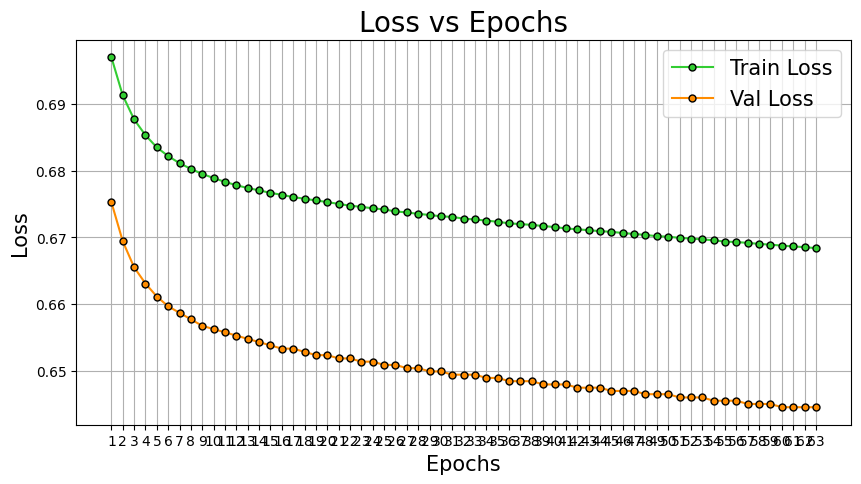

In [18]:
plot_losses(train_losses, test_losses)

In [ ]:
net.eval()
with torch.no_grad():
    scores = net(X_tensor_test.to(device))
    scores = scores.to('cpu').numpy()
net.train()

np.save(f'{savedir}/{subject}_{roi}_scores_{target}.npy',scores)

_____________________